In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam

## Data Loading

Config initialisation

In [24]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [25]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,…,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_responder_0_lagged,feature_responder_1_lagged,feature_responder_2_lagged,feature_responder_3_lagged,feature_responder_4_lagged,feature_responder_5_lagged,feature_responder_6_lagged,feature_responder_7_lagged,feature_responder_8_lagged,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,symbol_id,time_id,weight
i16,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i16,f32
0,0.127298,0.339121,-0.045494,0.151473,0,0,0,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,…,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.573992,-0.319932,-0.335376,-0.21128,-0.279558,-0.434355,-1.220439,0.214211,-0.257941,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,1,35,3.889038
0,0.114208,-1.419921,-0.505525,-0.258195,0,0,0,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,…,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,1,36,3.889038
0,0.118826,-1.293755,-0.809856,0.268584,0,0,0,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,…,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,1,37,3.889038
0,-0.216346,-0.021069,-0.425764,-0.005701,0,0,0,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,…,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,1,38,3.889038
0,-0.660073,2.168059,0.903407,-0.101644,0,0,0,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.572408,-0.297749,-0.126506,-0.083542,0.180433,-0.245343,0.052368,0.051568,-0.067317,0.5856

Define features and target

In [26]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

Split data

In [27]:
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

Data Wraper

In [28]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [29]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [30]:
train_data_loader = DataLoader(
    train_dataset, batch_size=2048, shuffle=False, num_workers=8
)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

## Model Evaluation

Model hyperameters

In [31]:
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

In [47]:
model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
)

Training hyperparameters

In [48]:
lr = 0.5e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 1.0
beta = 1.0

In [49]:
optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 50

  2%|▏         | 1/50 [00:06<05:11,  6.36s/it]

Epoch 01 | loss=130.934 | R2_rec_train=-0.6349 | R2_rec_val=-0.7182 | R2_sup_train=0.7726 | R2_sup_val=0.7086


  4%|▍         | 2/50 [00:13<05:21,  6.71s/it]

Epoch 02 | loss=102.148 | R2_rec_train=0.1214 | R2_rec_val=0.0878 | R2_sup_train=0.8271 | R2_sup_val=0.7268


  6%|▌         | 3/50 [00:20<05:29,  7.01s/it]

Epoch 03 | loss=99.193 | R2_rec_train=0.0593 | R2_rec_val=0.0952 | R2_sup_train=0.8279 | R2_sup_val=0.7372


  8%|▊         | 4/50 [00:27<05:18,  6.92s/it]

Epoch 04 | loss=95.252 | R2_rec_train=0.2025 | R2_rec_val=0.1538 | R2_sup_train=0.8284 | R2_sup_val=0.7627


 10%|█         | 5/50 [00:34<05:14,  6.99s/it]

Epoch 05 | loss=93.658 | R2_rec_train=0.2066 | R2_rec_val=0.0947 | R2_sup_train=0.8302 | R2_sup_val=0.7777


 12%|█▏        | 6/50 [00:40<04:56,  6.74s/it]

Epoch 06 | loss=92.923 | R2_rec_train=0.1516 | R2_rec_val=0.1775 | R2_sup_train=0.8309 | R2_sup_val=0.7977


 14%|█▍        | 7/50 [00:47<04:43,  6.59s/it]

Epoch 07 | loss=89.933 | R2_rec_train=0.2103 | R2_rec_val=0.1766 | R2_sup_train=0.8322 | R2_sup_val=0.8207


 16%|█▌        | 8/50 [00:54<04:41,  6.71s/it]

Epoch 08 | loss=87.747 | R2_rec_train=0.2212 | R2_rec_val=0.1544 | R2_sup_train=0.8328 | R2_sup_val=0.8306


 18%|█▊        | 9/50 [01:00<04:30,  6.60s/it]

Epoch 09 | loss=87.745 | R2_rec_train=0.2300 | R2_rec_val=0.1746 | R2_sup_train=0.8332 | R2_sup_val=0.8405


 20%|██        | 10/50 [01:06<04:18,  6.47s/it]

Epoch 10 | loss=86.078 | R2_rec_train=0.1902 | R2_rec_val=0.1718 | R2_sup_train=0.8333 | R2_sup_val=0.8401


 22%|██▏       | 11/50 [01:13<04:21,  6.70s/it]

Epoch 11 | loss=84.699 | R2_rec_train=0.1864 | R2_rec_val=0.1181 | R2_sup_train=0.8339 | R2_sup_val=0.8430


 24%|██▍       | 12/50 [01:20<04:12,  6.64s/it]

Epoch 12 | loss=84.741 | R2_rec_train=0.2505 | R2_rec_val=0.0685 | R2_sup_train=0.8341 | R2_sup_val=0.8400


 26%|██▌       | 13/50 [01:28<04:22,  7.10s/it]

Epoch 13 | loss=83.241 | R2_rec_train=0.1333 | R2_rec_val=0.1683 | R2_sup_train=0.8345 | R2_sup_val=0.8443


 28%|██▊       | 14/50 [01:35<04:15,  7.11s/it]

Epoch 14 | loss=82.528 | R2_rec_train=0.2481 | R2_rec_val=0.1517 | R2_sup_train=0.8349 | R2_sup_val=0.8461


 30%|███       | 15/50 [01:42<04:02,  6.94s/it]

Epoch 15 | loss=82.539 | R2_rec_train=0.2254 | R2_rec_val=0.1341 | R2_sup_train=0.8348 | R2_sup_val=0.8449


 32%|███▏      | 16/50 [01:48<03:52,  6.83s/it]

Epoch 16 | loss=81.717 | R2_rec_train=0.2066 | R2_rec_val=0.1506 | R2_sup_train=0.8353 | R2_sup_val=0.8441


 34%|███▍      | 17/50 [01:56<03:51,  7.01s/it]

Epoch 17 | loss=80.919 | R2_rec_train=0.2615 | R2_rec_val=0.0962 | R2_sup_train=0.8352 | R2_sup_val=0.8473


 36%|███▌      | 18/50 [02:02<03:41,  6.92s/it]

Epoch 18 | loss=80.193 | R2_rec_train=0.2164 | R2_rec_val=0.1363 | R2_sup_train=0.8354 | R2_sup_val=0.8408


 38%|███▊      | 19/50 [02:09<03:27,  6.70s/it]

Epoch 19 | loss=79.762 | R2_rec_train=0.1947 | R2_rec_val=0.2346 | R2_sup_train=0.8358 | R2_sup_val=0.8480


 40%|████      | 20/50 [02:15<03:21,  6.71s/it]

Epoch 20 | loss=79.753 | R2_rec_train=0.2699 | R2_rec_val=0.2154 | R2_sup_train=0.8360 | R2_sup_val=0.8472


 42%|████▏     | 21/50 [02:22<03:13,  6.68s/it]

Epoch 21 | loss=79.336 | R2_rec_train=0.2615 | R2_rec_val=0.1011 | R2_sup_train=0.8363 | R2_sup_val=0.8471


 44%|████▍     | 22/50 [02:29<03:07,  6.70s/it]

Epoch 22 | loss=79.561 | R2_rec_train=0.1811 | R2_rec_val=0.2044 | R2_sup_train=0.8362 | R2_sup_val=0.8454


 46%|████▌     | 23/50 [02:36<03:05,  6.87s/it]

Epoch 23 | loss=78.922 | R2_rec_train=0.2627 | R2_rec_val=0.1095 | R2_sup_train=0.8363 | R2_sup_val=0.8437


 48%|████▊     | 24/50 [02:42<02:54,  6.72s/it]

Epoch 24 | loss=79.280 | R2_rec_train=0.2381 | R2_rec_val=0.2086 | R2_sup_train=0.8363 | R2_sup_val=0.8451


 50%|█████     | 25/50 [02:49<02:47,  6.70s/it]

Epoch 25 | loss=77.524 | R2_rec_train=0.2279 | R2_rec_val=0.1458 | R2_sup_train=0.8365 | R2_sup_val=0.8453


 52%|█████▏    | 26/50 [02:56<02:39,  6.67s/it]

Epoch 26 | loss=77.056 | R2_rec_train=0.2779 | R2_rec_val=0.1200 | R2_sup_train=0.8367 | R2_sup_val=0.8468


 54%|█████▍    | 27/50 [03:02<02:31,  6.58s/it]

Epoch 27 | loss=77.333 | R2_rec_train=0.2564 | R2_rec_val=0.1896 | R2_sup_train=0.8367 | R2_sup_val=0.8468


 56%|█████▌    | 28/50 [03:08<02:22,  6.49s/it]

Epoch 28 | loss=76.785 | R2_rec_train=0.2530 | R2_rec_val=0.0683 | R2_sup_train=0.8369 | R2_sup_val=0.8467


 58%|█████▊    | 29/50 [03:14<02:14,  6.40s/it]

Epoch 29 | loss=76.918 | R2_rec_train=0.2642 | R2_rec_val=0.1970 | R2_sup_train=0.8369 | R2_sup_val=0.8473


 60%|██████    | 30/50 [03:20<02:02,  6.14s/it]

Epoch 30 | loss=77.431 | R2_rec_train=0.2774 | R2_rec_val=0.1876 | R2_sup_train=0.8370 | R2_sup_val=0.8456


 62%|██████▏   | 31/50 [03:26<01:54,  6.02s/it]

Epoch 31 | loss=76.423 | R2_rec_train=0.2220 | R2_rec_val=0.1383 | R2_sup_train=0.8369 | R2_sup_val=0.8445


 64%|██████▍   | 32/50 [03:32<01:49,  6.09s/it]

Epoch 32 | loss=77.141 | R2_rec_train=0.2243 | R2_rec_val=0.1343 | R2_sup_train=0.8369 | R2_sup_val=0.8467


 66%|██████▌   | 33/50 [03:38<01:46,  6.24s/it]

Epoch 33 | loss=75.353 | R2_rec_train=0.2573 | R2_rec_val=0.1252 | R2_sup_train=0.8371 | R2_sup_val=0.8467


 68%|██████▊   | 34/50 [03:45<01:39,  6.23s/it]

Epoch 34 | loss=74.905 | R2_rec_train=0.2849 | R2_rec_val=0.2240 | R2_sup_train=0.8373 | R2_sup_val=0.8460


 70%|███████   | 35/50 [03:51<01:34,  6.27s/it]

Epoch 35 | loss=75.234 | R2_rec_train=0.2472 | R2_rec_val=-0.1362 | R2_sup_train=0.8374 | R2_sup_val=0.8472


 72%|███████▏  | 36/50 [03:57<01:26,  6.18s/it]

Epoch 36 | loss=75.278 | R2_rec_train=0.2870 | R2_rec_val=0.0504 | R2_sup_train=0.8373 | R2_sup_val=0.8470


 74%|███████▍  | 37/50 [04:03<01:20,  6.16s/it]

Epoch 37 | loss=74.681 | R2_rec_train=0.2702 | R2_rec_val=0.2190 | R2_sup_train=0.8375 | R2_sup_val=0.8467


 76%|███████▌  | 38/50 [04:10<01:15,  6.31s/it]

Epoch 38 | loss=74.945 | R2_rec_train=0.2124 | R2_rec_val=0.0970 | R2_sup_train=0.8374 | R2_sup_val=0.8468


 78%|███████▊  | 39/50 [04:15<01:06,  6.07s/it]

Epoch 39 | loss=74.179 | R2_rec_train=0.2725 | R2_rec_val=0.1302 | R2_sup_train=0.8371 | R2_sup_val=0.8445


 80%|████████  | 40/50 [04:22<01:02,  6.25s/it]

Epoch 40 | loss=74.037 | R2_rec_train=0.2696 | R2_rec_val=0.1932 | R2_sup_train=0.8374 | R2_sup_val=0.8469


 82%|████████▏ | 41/50 [04:29<00:58,  6.47s/it]

Epoch 41 | loss=73.854 | R2_rec_train=0.1505 | R2_rec_val=0.2751 | R2_sup_train=0.8376 | R2_sup_val=0.8490


 84%|████████▍ | 42/50 [04:35<00:50,  6.37s/it]

Epoch 42 | loss=73.468 | R2_rec_train=0.2889 | R2_rec_val=0.2075 | R2_sup_train=0.8376 | R2_sup_val=0.8469


 86%|████████▌ | 43/50 [04:41<00:44,  6.32s/it]

Epoch 43 | loss=73.184 | R2_rec_train=0.2519 | R2_rec_val=0.2499 | R2_sup_train=0.8377 | R2_sup_val=0.8456


 88%|████████▊ | 44/50 [04:49<00:39,  6.60s/it]

Epoch 44 | loss=73.440 | R2_rec_train=0.3165 | R2_rec_val=0.2472 | R2_sup_train=0.8375 | R2_sup_val=0.8471


 90%|█████████ | 45/50 [04:55<00:32,  6.57s/it]

Epoch 45 | loss=73.294 | R2_rec_train=0.2563 | R2_rec_val=0.2527 | R2_sup_train=0.8377 | R2_sup_val=0.8461


 92%|█████████▏| 46/50 [05:02<00:26,  6.55s/it]

Epoch 46 | loss=73.237 | R2_rec_train=0.3146 | R2_rec_val=0.2605 | R2_sup_train=0.8380 | R2_sup_val=0.8473


 94%|█████████▍| 47/50 [05:08<00:19,  6.64s/it]

Epoch 47 | loss=73.073 | R2_rec_train=0.2263 | R2_rec_val=0.2460 | R2_sup_train=0.8379 | R2_sup_val=0.8438


 96%|█████████▌| 48/50 [05:15<00:13,  6.56s/it]

Epoch 48 | loss=73.497 | R2_rec_train=0.2430 | R2_rec_val=0.2224 | R2_sup_train=0.8376 | R2_sup_val=0.8418


 98%|█████████▊| 49/50 [05:21<00:06,  6.35s/it]

Epoch 49 | loss=73.146 | R2_rec_train=0.3153 | R2_rec_val=0.2359 | R2_sup_train=0.8381 | R2_sup_val=0.8445


100%|██████████| 50/50 [05:27<00:00,  6.56s/it]

Epoch 50 | loss=73.070 | R2_rec_train=0.2884 | R2_rec_val=0.1301 | R2_sup_train=0.8380 | R2_sup_val=0.8465


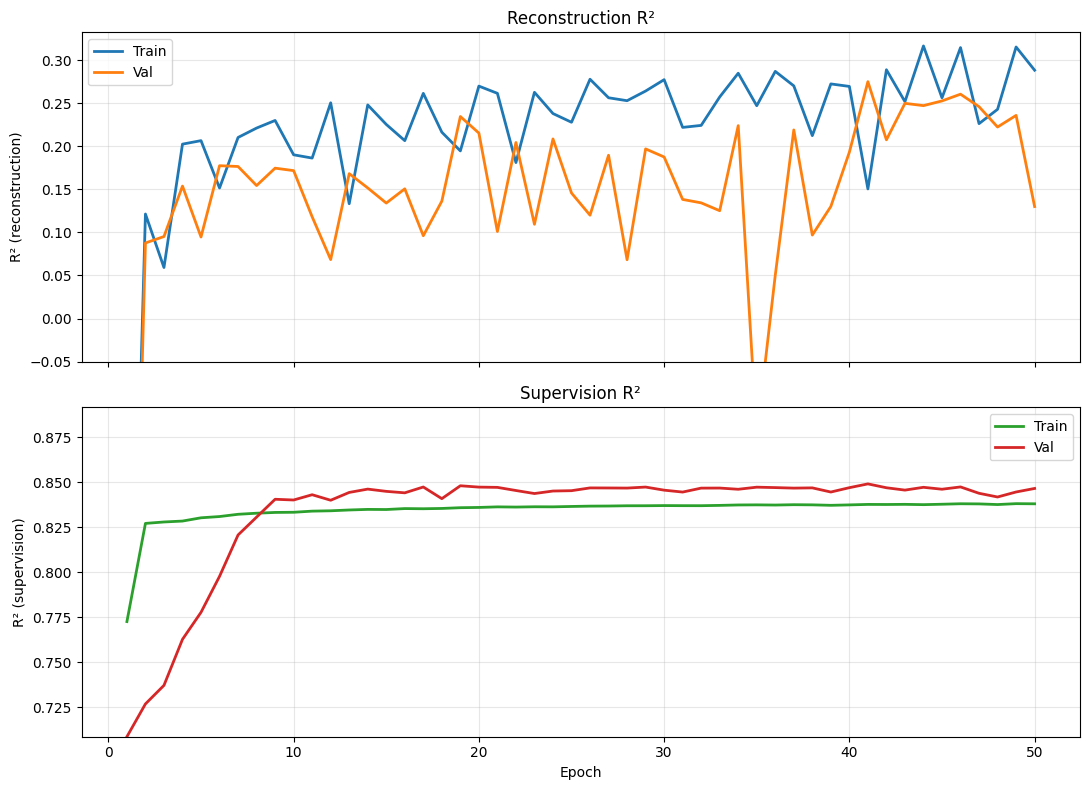

In [50]:
res = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)